# Kaggle's Titanic Starter Competition: first attempt

Quick and dirty solution(s) for Kaggle's starter competition [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic).

In this notebook my goal was to get to a submission as quickly as possible, and as such I've skipped exploratory analysis and dropped a couple of variables that might be useful. But by making some quick decisions on how to preprocess data and applying off the shelf models, we could compare results and attempt a couple of submissions, getting up to 0.736 accuracy. From what I read it should be possible to get closer to 0.8, but this is a decent start.

## Data pre-processing

We need to load in the training data set and decide on pre-processing steps including filling in missing data, normalizing values etc.

```
VARIABLE DESCRIPTIONS:
survival        Survival
                (0 = No; 1 = Yes)
pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
name            Name
sex             Sex
age             Age
sibsp           Number of Siblings/Spouses Aboard
parch           Number of Parents/Children Aboard
ticket          Ticket Number
fare            Passenger Fare
cabin           Cabin
embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)
```

### Loading the data

In [1]:
import pandas as pd

training_data = pd.read_csv('train.csv')

training_data.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,NaN,C


### Finding features with missing data

Looks like there are plenty of columns with missing data.

In [2]:
print("Total rows: {}".format(training_data.size))

print("Variables with missing rows:")
training_data.isnull().sum()

Total rows: 10692
Variables with missing rows:


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Handling missing data, mapping categorical data and scaling 

Things we need to take care of in preprocessing data:

- Selecting features: after eyeballing the data, we drop a couple of columns that seem like a pain to deal with and/or are missing many values.
- Missing values: it appears the only missing values (among features we're working with) are for quantitative variables. For those values, we'll replace with median value for that column.
- Categorical data: we map binary variables to 0, 1
- Scaling:
  - categorical values: we push to -1, 1
  - quantitative: we use scikit-learn's standard scalar to center the feature columns at mean 0 with standard deviation 1 so that the feature columns take the form of a normal distribution
  - note: we provide an option to not scale as it isn't necessary for tree based models
  
The helper method I developed to perform this scaling is below


In [3]:
# %load titanic.py
from sklearn.preprocessing import StandardScaler


def make_preprocesser(training_data):
    """
    Constructs a preprocessing function ready to apply to new dataframes.

    Crucially, the interpolating that is done based on the training data set
    is remembered so it can be applied to test datasets (e.g the mean age that
    is used to fill in missing values for 'Age' will be fixed based on the mean
    age within the training data set).

    Summary by column:

    ['PassengerId',
     'Survived',    # this is our target, not a feature
     'Pclass',      # keep as is: ordinal value should work, even though it's inverted (higher number is lower class cabin)
     'Name',        # omit (could try some fancy stuff like inferring ethnicity, but skip for now)
     'Sex',         # code to 0 / 1
     'Age',         # replace missing with median
     'SibSp',
     'Parch',
     'Ticket',      # omit (doesn't seem like low hanging fruit, could look more closely for pattern later)
     'Fare',        # keep, as fare could be finer grained proxy for socio economic status, sense of entitlement / power in getting on boat
     'Cabin',       # omit (10% are missing values, could look more closely later, one idea would be to break this out into a few different boolean variables for major section, A->E)
     'Embarked']    # omit (could one-hot encode it, but can't see how this would affect survivorship, let's be lazy to start)

    Params:
        df: pandas.DataFrame containing the training data
    Returns:
        fn: a function to preprocess a dataframe (either before training or fitting a new dataset)
    """

    def pick_features(df):
        return df[['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']]

    # save median Age so we can use it to fill in missing data consistently
    # on any dataset
    median_age_series = training_data[['Age', 'Fare']].median()

    def fix_missing(df):
        return df.fillna(median_age_series)

    def map_categorical(df):
        df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})
        return df

    # We want standard scaling fit on the training data, so we get a scaler ready
    # for application now. It needs to be applied to data that already has the other
    # pre-processing applied.
    training_data_all_but_scaled = map_categorical(fix_missing(pick_features(training_data)))
    stdsc = StandardScaler()
    stdsc.fit(training_data_all_but_scaled[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])

    def scale_df(df):
        df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']] = \
            stdsc.transform(df[['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']])
        df[['Sex']] = df[['Sex']].applymap(lambda x: 1 if x == 1 else -1)
        return df

    def preprocess(df, scale=True):
        """
        Preprocesses a dataframe so it is ready for use with a model (either for training or prediction).

        Params:
            scale: whether to apply feature scaling. E.g with random forests feature scaling isn't necessary.
        """
        all_but_scaled = map_categorical(fix_missing(pick_features(df)))
        if scale:
            return scale_df(all_but_scaled)
        else:
            return all_but_scaled

    return preprocess


## Applying off the shelf classifiers on the way to quick first submission

Let's try out a few classifiers on test vs training portions of the dataset, using our preprocessor function as appropriate.

Note that we split the training set provided into a training and test set so we can get some insight into how well each model might generalize to unseen data.

In [4]:
preprocess = make_preprocesser(training_data)

td_preprocessed_unscaled = preprocess(training_data, scale=False)

td_preprocessed_unscaled.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,3,0,22,1,0,7.2500
1,2,1,1,38,1,0,71.2833
2,3,3,1,26,0,0,7.9250
3,4,1,1,35,1,0,53.1000
4,5,3,0,35,0,0,8.0500
5,6,3,0,28,0,0,8.4583
6,7,1,0,54,0,0,51.8625
7,8,3,0,2,3,1,21.0750
8,9,3,1,27,0,2,11.1333
9,10,2,1,14,1,0,30.0708


In [5]:
td_preprocessed = preprocess(training_data, scale=True)

td_preprocessed.head(10)

,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,1,0.827377,-1,-0.565736,0.432793,-0.473674,-0.502445
1,2,-1.566107,1,0.663861,0.432793,-0.473674,0.786845
2,3,0.827377,1,-0.258337,-0.474545,-0.473674,-0.488854
3,4,-1.566107,1,0.433312,0.432793,-0.473674,0.420730
4,5,0.827377,-1,0.433312,-0.474545,-0.473674,-0.486337
5,6,0.827377,-1,-0.104637,-0.474545,-0.473674,-0.478116
6,7,-1.566107,-1,1.893459,-0.474545,-0.473674,0.395814
7,8,0.827377,-1,-2.102733,2.247470,0.767630,-0.224083
8,9,0.827377,1,-0.181487,-0.474545,2.008933,-0.424256
9,10,-0.369365,1,-1.180535,0.432793,-0.473674,-0.042956


In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split

for name, should_scale, model in [
        ("Decision Tree", False, DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=0)),
        ("Random forest", False, RandomForestClassifier(criterion='entropy',
                                    n_estimators=10, 
                                    random_state=1,
                                    n_jobs=2)),
        ("Logistic Regression", True, LogisticRegression(C=100.0, random_state=0)),
        ("Linear SVM", True, SVC(kernel='linear', C=1.0, random_state=0)),
        ("Kernel SVM", True, SVC(kernel='rbf', random_state=0, gamma=0.10, C=10.0))]:
    pre_processed = td_preprocessed if should_scale else td_preprocessed_unscaled
    X = pre_processed.loc[:,'Pclass':]
    y = training_data['Survived']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    model.fit(X_train, y_train)
    print("{} training/test accuracy: {:.2f} | {:.2f}".format(
            name, 
            accuracy_score(y_train, model.predict(X_train)),
            accuracy_score(y_test, model.predict(X_test))))


Decision Tree training/test accuracy: 0.84 | 0.82
Random forest training/test accuracy: 0.96 | 0.82
Logistic Regression training/test accuracy: 0.79 | 0.80
Linear SVM training/test accuracy: 0.79 | 0.79
Kernel SVM training/test accuracy: 0.84 | 0.81


The biggest delta between training and test is with random forests which suggests that when trained it's apparent advantage could be lost due to overfitting.

## First submissions to Kaggle

Let's make our first submissions. We can re-train the most promising off the shelf classifier, random forest, on the entire training data set, run it on kaggle's test data set and submit.

In [7]:
fully_trained_forest = RandomForestClassifier(criterion='entropy',
                                    n_estimators=10, 
                                    random_state=1,
                                    n_jobs=2)
X = td_preprocessed_unscaled.loc[:,'Pclass':]
y = training_data['Survived']
fully_trained_forest.fit(X, y)
print("Random forest full training set accuracy: {:.2f}".format(accuracy_score(y, fully_trained_forest.predict(X))))

test_data = pd.read_csv('test.csv')
test_data_preprocessed = preprocess(test_data, scale=False)
test_data_preprocessed.head()

Random forest full training set accuracy: 0.96


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,892,3,0,34.5,0,0,7.8292
1,893,3,1,47.0,1,0,7.0000
2,894,2,0,62.0,0,0,9.6875
3,895,3,0,27.0,0,0,8.6625
4,896,3,1,22.0,1,1,12.2875


In [8]:
test_data_predict = fully_trained_forest.predict(test_data_preprocessed.loc[:,'Pclass':])

submission_df = test_data_preprocessed[['PassengerId']].copy()
submission_df['Survived'] = test_data_predict

submission_df.to_csv(
    'titanic_submission_random_forest_1.csv',
    index=False)

submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,1
3,895,1
4,896,0


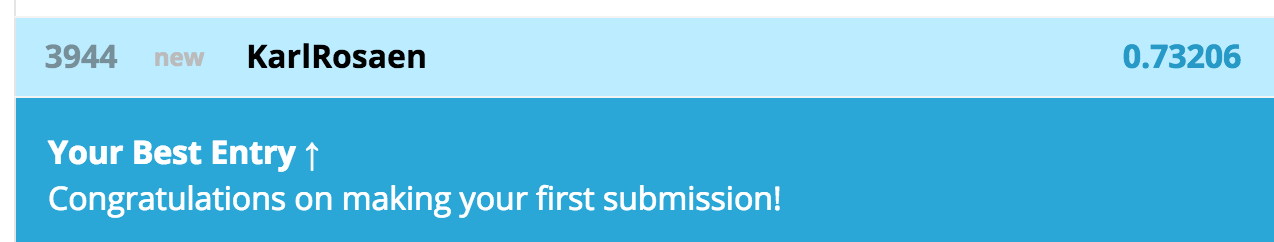

In [9]:
from IPython.display import Image
Image(filename='kaggle-submission-random-forest.png', width=600) 

It's interesting that we only acheived 73% accuracy when our local test set was 82%.

Before digging deeper, let's also try a submission using logistic regression.

In [10]:
fully_trained_lgr = LogisticRegression(C=100.0, random_state=0)

X_scaled = td_preprocessed.loc[:,'Pclass':]
y = training_data['Survived']
fully_trained_lgr.fit(X_scaled, y)
print("Logistic Regression full training set accuracy: {:.2f}".format(
        accuracy_score(y, fully_trained_lgr.predict(X_scaled))))

test_data = pd.read_csv('test.csv')
test_data_preprocessed_scaled = preprocess(test_data, scale=True)
test_data_preprocessed_scaled.head()

Logistic Regression full training set accuracy: 0.79


,PassengerId,Pclass,Sex,Age,SibSp,Parch,Fare
0,892,0.827377,-1,0.394887,-0.474545,-0.473674,-0.490783
1,893,0.827377,1,1.355510,0.432793,-0.473674,-0.507479
2,894,-0.369365,-1,2.508257,-0.474545,-0.473674,-0.453367
3,895,0.827377,-1,-0.181487,-0.474545,-0.473674,-0.474005
4,896,0.827377,1,-0.565736,0.432793,0.767630,-0.401017


In [11]:
test_data_predict = fully_trained_lgr.predict(test_data_preprocessed_scaled.loc[:,'Pclass':])

submission_df = test_data_preprocessed_scaled[['PassengerId']].copy()
submission_df['Survived'] = test_data_predict

submission_df.to_csv(
    'titanic_submission_logistic_regression_1.csv',
    index=False)

submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1


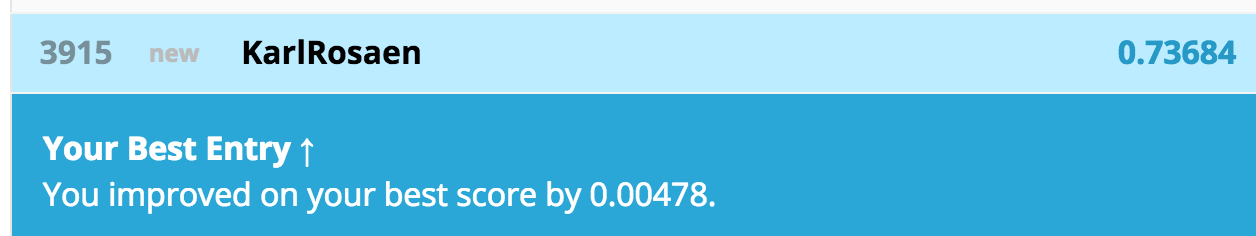

In [12]:
Image(filename='kaggle-submission-logistic-regression.png', width=600) 

As earlier suspected, any advantage the random forest model had over logistic regression was due to overfitting and didn't generalize to perform any better once submitted to Kaggle. Logistic regression performed about the same.